## State preparation

A vast majority of quantum algorithms (_i.e._ Quantum Phase Estimation) require to prepare specific initial states to run correctly. In this tutorial, we show how an arbitrary state can be prepared using pulse sequence optimization capabilities of `PulserDiff`.

In [ ]:
import torch

from torch import Tensor
from pulser import Sequence, Pulse, Register 
from pulser.devices import VirtualDevice
from pulser.waveforms import CustomWaveform
from pulser.channels import Rydberg

from pulser_diff.model import QuantumModel

from pyqtorch.utils import SolverType

from math import pi, sin
from pulser_diff.utils import basis_state, interpolate_sine


MockDevice = VirtualDevice(
    name="MockDevice",
    dimensions=2,
    rydberg_level=60,
    channel_objects=(
        Rydberg.Global(6.28, 12.566370614359172, max_duration=None),
    ),
)

Let us first define a 6-qubit register.

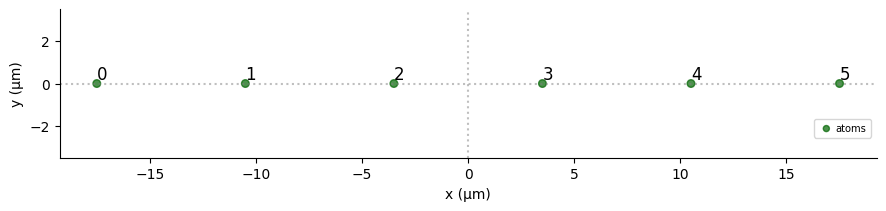

In [4]:
dist = torch.tensor([7.0])
n_qubits = 6
reg = Register.rectangle(1, n_qubits, dist)
reg.draw()

In this simulation we choose the state $\left|1...1\right\rangle $ as the target state to prepare whereas we initialize the optimization process with the zero state $\left|0...0\right\rangle $. A metric for state similarity is defined as the state fidelity $F=|\left.\left\langle \psi_{\rm{final}}\right| \psi_{\rm{target}} \right\rangle |^2$ which serves to define the optimization loss as $L=1-F$.

In [ ]:
# Define the |1...1> target state.
target_state = basis_state(2 ** n_qubits, 0).to(dtype=torch.complex128)

def fidelity(state1: Tensor, state2: Tensor) -> Tensor:
    return torch.abs(torch.matmul(state1.mH, state2)) ** 2

We will use custom-pulse sequence with amplitude and detuning waveforms constructed using sine function interpolation.


call_param_values.amp_custom_0
Parameter containing:
tensor([ 0.1710, -0.6696, -0.6378, -0.2017, -0.4131,  0.6563, -0.8746,  0.7353,
        -0.9874,  0.3153,  0.8834,  0.8186,  0.4730,  0.0033,  0.2423, -0.1764,
         0.3488, -0.6039,  0.0627, -0.5089, -0.6097, -0.6837, -0.0811,  0.5327,
        -0.6679,  0.1670,  0.5462,  0.4381,  0.3342,  0.2942],
       requires_grad=True)
-------
call_param_values.det_custom_0
Parameter containing:
tensor([-0.1795, -0.0115, -0.5285, -0.9943,  0.7078,  0.9741, -0.4146,  0.3350,
         0.4035,  0.3226,  0.4535,  0.6059,  0.8024, -0.5279, -0.4816, -0.8822,
         0.7213, -0.8643,  0.1060,  0.3222,  0.2893,  0.5684, -0.7081,  0.6178,
         0.3030, -0.3070,  0.1151,  0.8919,  0.3060, -0.1755],
       requires_grad=True)
-------


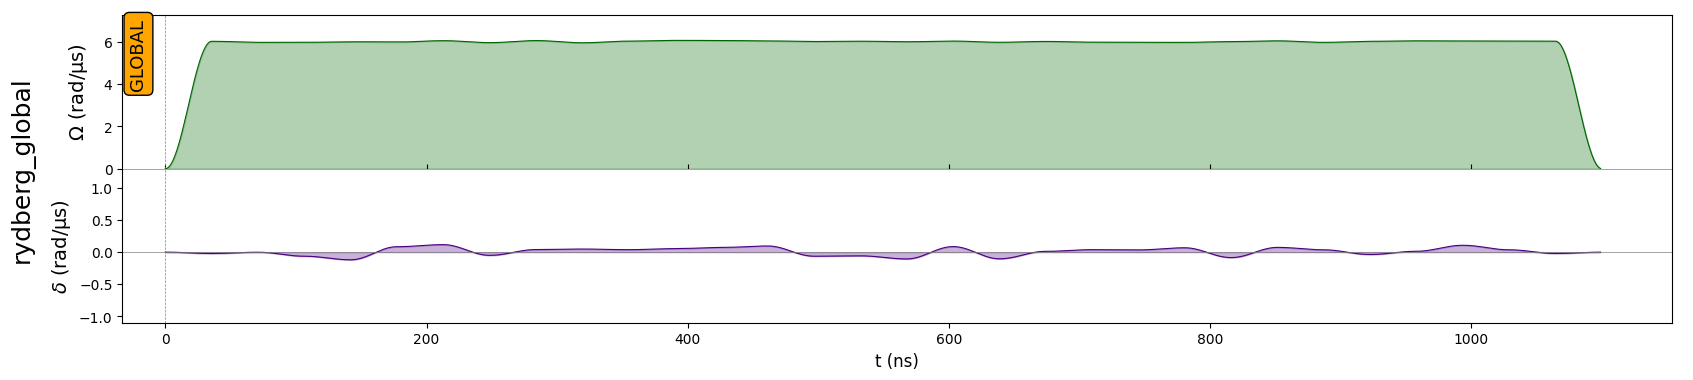

In [26]:
# Define sequence parameters.
duration = 1100
n_param = 30
gamma = 0.02

# Create the sequence and declare the channels.
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# Define the custom-shaped pulse.
amp_custom_param = seq.declare_variable("amp_custom", size=duration)
det_custom_param = seq.declare_variable("det_custom", size=duration)
cust_amp = CustomWaveform(amp_custom_param)
cust_det = CustomWaveform(det_custom_param)
pulse_custom = Pulse(cust_amp, cust_det, 0.0)

# Add the pulse.
seq.add(pulse_custom, "rydberg_global")

# Create the sine interpolation matrix.
interp_mat = interpolate_sine(n_param, duration)

# Define the waveform functions.
def custom_wf_amp(params):
    return torch.matmul(interp_mat, int(MockDevice.channels["rydberg_global"].max_amp) * torch.sigmoid(gamma * params))

def custom_wf_det(params):
    return torch.matmul(interp_mat, int(MockDevice.channels["rydberg_global"].max_abs_detuning) * torch.tanh(gamma * params))

# Define the pulse parameters.
amp_values = 2 * torch.rand(n_param, requires_grad=True) - 1.0
det_values = 2 * torch.rand(n_param, requires_grad=True) - 1.0
trainable_params = {
    "amp_custom": ((amp_values,), custom_wf_amp),
    "det_custom": ((det_values,), custom_wf_det),
}

# Create the quantum model from the sequence.
model = QuantumModel(seq, trainable_params, sampling_rate=0.05, solver=SolverType.DP5_SE)

# List all trainable parameters of the model.
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')

model.built_seq.draw()

Finally, we run the optimization loop and record the best parameter set for the lowest loss.

In [27]:
# Define parameter values and initialize the optimizer and the scheduler.
initial_lr = 5.0
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
epochs = 1000
min_change = 0.01
num_loss_plateu = 6

loss_dict = {}
for t in range(epochs):
    # Calculate the loss with the final state.
    _, final_state = model.forward()
    loss = 1 - fidelity(target_state, final_state[-1])
    
    # Backpropagation.
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Log the loss value together with model params.
    loss_dict[t] = {"loss": float(loss), "params": {name: param.data.clone().detach() for name, param in model.named_parameters()}}

    if len(loss_dict) > num_loss_plateu and loss > 0.1:
        last_losses = [loss_dict[i]["loss"] for i in range(t-num_loss_plateu, t + 1)]
        diffs = [abs(last_losses[i] - last_losses[i - 1]) for i in range(-1, -num_loss_plateu-1, -1)]
        if all(diff < min_change for diff in diffs):
            # Reset the learning rate to the initial value and recreate the scheduler.
            for param_group in optimizer.param_groups:
                param_group['lr'] = initial_lr
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
        else:
            # Update the learning rate.
            scheduler.step()
    else:
        # Update the learning rate.
        scheduler.step()

    if loss < 0.0001:
        print(f"[t={t}]loss: {float(loss):>7f}")
        break

    # Update the sequence with changed pulse parameter values.
    model.update_sequence()

    if (t % 50 == 0) or (t == epochs-1):
        # Print the learning rate.
        lr = scheduler.get_last_lr()[0]
        print(f"Epoch {t:03}: Learning Rate = {lr:.6f}")

        print(f"[t={t}]loss: {float(loss):>7f}")
        print("**************************************")

# Get the best parameter set.
sorted_losses = dict(sorted(loss_dict.items(), key=lambda x: x[1]["loss"]))
best_param_set = list(sorted_losses.values())[0]["params"]
print(f"Best loss: {list(sorted_losses.values())[0]['loss']} after {list(sorted_losses.keys())[0]} epochs.")

Epoch 000: Learning Rate = 4.995067
[t=0]loss: 0.999458
**************************************
Epoch 050: Learning Rate = 4.921458
[t=50]loss: 0.079615
**************************************
Epoch 100: Learning Rate = 0.078542
[t=100]loss: 0.040372
**************************************
Epoch 150: Learning Rate = 4.921458
[t=150]loss: 0.021692
**************************************
Epoch 200: Learning Rate = 0.078542
[t=200]loss: 0.014938
**************************************
Epoch 250: Learning Rate = 4.921458
[t=250]loss: 0.010457
**************************************
Epoch 300: Learning Rate = 0.078542
[t=300]loss: 0.008373
**************************************
Epoch 350: Learning Rate = 4.921458
[t=350]loss: 0.006738
**************************************
Epoch 400: Learning Rate = 0.078542
[t=400]loss: 0.005820
**************************************
Epoch 450: Learning Rate = 4.921458
[t=450]loss: 0.004981
**************************************
Epoch 500: Learning Rate = 0.0785

In [28]:
# update model params with the best optimized parameter values
for n, p in model.named_parameters():
    p.data = best_param_set[n]
model.update_sequence()

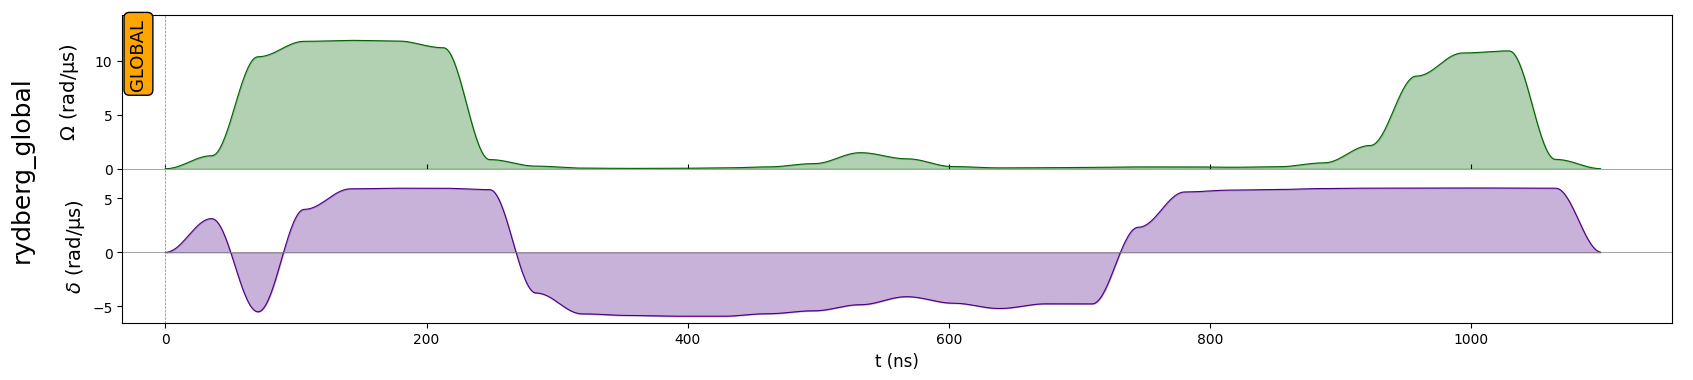

call_param_values.amp_custom_0
Parameter containing:
tensor([-109.8368,   92.4695,  202.7724,  230.8793,  213.1587,  132.3215,
        -128.9406, -194.4135, -265.8430, -296.8776, -283.3639, -256.2733,
        -212.3780, -159.6839,  -97.8577, -124.3773, -203.9898, -251.4854,
        -243.6192, -227.4387, -212.6938, -210.1281, -223.0002, -209.8238,
        -152.4837,  -76.1234,   45.9807,  106.1897,  115.1693, -127.7764],
       requires_grad=True)
----------------
call_param_values.det_custom_0
Parameter containing:
tensor([  28.8744,  -78.7406,   40.0382,  116.4371,  133.6737,  131.5698,
         103.3717,  -36.8735,  -91.6051, -108.5487, -123.9467, -126.2932,
         -90.3078,  -74.1485,  -56.0920,  -41.9021,  -52.8627,  -65.9430,
         -54.2068,  -54.3430,   20.4778,   83.7686,   98.0866,  105.4014,
         122.9699,  135.6744,  141.4354,  145.4670,  142.7416,  134.6813],
       requires_grad=True)
----------------
State fidelity: 99.79%


In [29]:
# visualize the optimized custom pulse
model.built_seq.draw(draw_phase_curve=True)

for name, param in model.named_parameters():
    print(name)
    print(param)
    print("----------------")

_, final_state = model.forward()
print(f"State fidelity: {100 * float(fidelity(final_state[-1], target_state)):.2f}%")

We can see that that executing the pulse with the optimized custom waveform displayed above results in the transformation $\left|0...0 \right \rangle \rightarrow \left|1...1\right\rangle $ with 99.99% accuracy in the presence of inter-qubit interaction.